# Groundwater transport modeling



In [21]:
import nlmod
import numpy as np
import xarray as xr
import flopy as fp
import matplotlib.pyplot as plt

nlmod.show_versions()

Python version: 3.9.7
NumPy version: 1.21.2
Xarray version: 2022.10.0
Matplotlib version: 3.7.0

nlmod version: 0.5.2b


In [22]:
nlmod.util.get_color_logger("INFO");

In [23]:
# model settings
model_ws = "hondsbossche"
model_name = "hondsbossche"

transport = True

figdir, cachedir = nlmod.util.get_model_dirs(model_ws)

# extent_ijmuiden = [95000.0, 105000.0, 494000.0, 500000.0]
extent_hbossche = [103700, 106700, 527550, 528550]
delr = 100.0
delc = 100.0

steady_state = True
start_time = "2015-1-1"

add_northsea = True

starting_head = 1.0

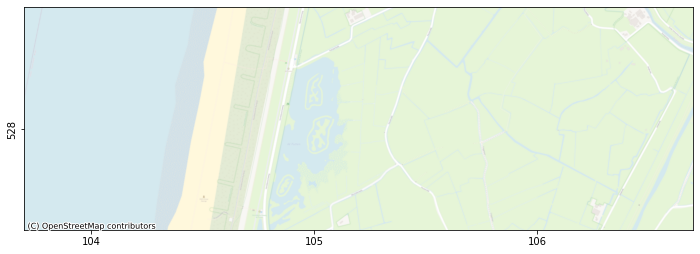

In [24]:
fig, ax = nlmod.plot.get_map(extent_hbossche, background="OpenStreetMap.Mapnik")

In [25]:
layer_model = nlmod.read.regis.get_combined_layer_models(
    extent_hbossche,
    use_regis=True,
    regis_botm_layer="MSz1",
    use_geotop=True,
    cachedir=cachedir,
    cachename="combined_layer_ds.nc",
)

# create a model ds
ds = nlmod.to_model_ds(
    layer_model,
    model_name,
    model_ws,
    delr=delr,
    delc=delc,
    transport=transport,
)

# add time discretisation
ds = nlmod.time.set_ds_time(
    ds,
    start_time=start_time,
    steady_state=steady_state,
    perlen=365 * 5,
)

if add_northsea:
    ds = nlmod.read.rws.add_northsea(ds, cachedir=cachedir)

if ds.transport == 1:
    ds = nlmod.gwt.set_default_transport_parameters(ds, transport_type="chloride")

INFO:nlmod.cache:using cached data -> combined_layer_ds.nc
INFO:nlmod.dims.base:resample layer model data to structured modelgrid
INFO:nlmod.read.rws:nan values at the northsea are filled using the bathymetry from jarkus
INFO:nlmod.cache:module of function get_northsea recently modified, not using cache
INFO:nlmod.cache:caching data -> sea_ds.nc
INFO:nlmod.cache:using cached data -> bathymetry_ds.nc


In [26]:
cl = xr.open_dataset("../../../pwn_diep/data/3dchloride_result.nc")

# interpolate to modelgrid using nearest
cli = cl.sel(percentile="p50").interp(x=ds.x, y=ds.y, method="nearest")
cli

<xarray.Dataset>
Dimensions:      (layer: 46, y: 10, x: 30)
Coordinates:
    percentile   <U3 'p50'
  * layer        (layer) int32 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46
    z            (layer) float64 110.0 80.0 50.0 40.0 ... -280.0 -300.0 -500.0
    dz           (layer) float64 30.0 30.0 20.0 10.0 ... 20.0 20.0 110.0 200.0
    top          (layer) float64 125.0 95.0 65.0 45.0 ... -270.0 -290.0 -400.0
    bottom       (layer) float64 95.0 65.0 45.0 35.0 ... -290.0 -400.0 -600.0
    dy           float64 -250.0
    dx           float64 250.0
  * x            (x) float64 1.038e+05 1.038e+05 ... 1.066e+05 1.066e+05
  * y            (y) float64 5.285e+05 5.284e+05 ... 5.277e+05 5.276e+05
Data variables:
    3d-chloride  (layer, y, x) float64 nan nan nan ... 1.529e+04 1.529e+04

In [27]:
# aggregate chloride to our layer model using weighted mean
cli_da = nlmod.layers.aggregate_by_weighted_mean_to_ds(ds, cli, "3d-chloride")

# interpolate NaNs nearest
for ilay in range(cli_da.shape[0]):
    cli_da.values[ilay] = nlmod.resample.fillnan_da(
        da=cli_da.isel(layer=ilay), method="nearest"
    )

# set chloride data in model dataset
ds["chloride"] = cli_da

In [28]:
# create simulation
sim = nlmod.sim.sim(ds)

# create time discretisation
tdis = nlmod.sim.tdis(ds, sim)

# create ims
ims = nlmod.sim.ims(sim, complexity="MODERATE")

INFO:nlmod.sim.sim:creating modflow SIM
INFO:nlmod.sim.sim:creating modflow TDIS
INFO:nlmod.sim.sim:creating modflow IMS


In [29]:
# create groundwater flow model
gwf = nlmod.gwf.gwf(ds, sim)
sim.register_ims_package(ims, [gwf.name])

# Create discretization
dis = nlmod.gwf.dis(ds, gwf)

# create node property flow
npf = nlmod.gwf.npf(ds, gwf)

# Create the initial conditions package
ic = nlmod.gwf.ic(ds, gwf, starting_head=starting_head)

# Create the output control package
oc = nlmod.gwf.oc(ds, gwf)

INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow DIS
INFO:nlmod.gwf.gwf:creating modflow NPF
INFO:nlmod.gwf.gwf:creating modflow IC
INFO:nlmod.gwf.gwf:creating modflow OC


In [30]:
# voeg grote oppervlaktewaterlichamen toe o.b.v. shapefile
da_name = "rws_oppwater"
rws_ds = nlmod.read.rws.get_surface_water(
    ds, da_name, cachedir=ds.cachedir, cachename=da_name
)
# add data to model dataset
ds.update(rws_ds)

# build ghb package
ghb = nlmod.gwf.ghb(ds, gwf, da_name, auxiliary=18_000.0)

INFO:nlmod.cache:module of function get_surface_water recently modified, not using cache
INFO:nlmod.cache:caching data -> rws_oppwater.nc
INFO:nlmod.gwf.gwf:creating modflow GHB


In [31]:
# surface level drain
ahn_ds = nlmod.read.ahn.get_ahn(ds, cachedir=ds.cachedir, cachename="ahn")
# add data to model dataset
ds.update(ahn_ds)

# build surface level drain package
drn = nlmod.gwf.surface_drain_from_ds(ds, gwf, resistance=10.0)

INFO:nlmod.cache:coordinate x has different values in cached dataset, not using cache


INFO:nlmod.cache:caching data -> ahn.nc


In [32]:
# download knmi recharge data
knmi_ds = nlmod.read.knmi.get_recharge(ds, cachedir=ds.cachedir, cachename="recharge")
# update model dataset
ds.update(knmi_ds)

# create recharge package
rch = nlmod.gwf.rch(ds, gwf, mask=ds["rws_oppwater_cond"] == 0)

INFO:nlmod.cache:using cached data -> recharge.nc
INFO:nlmod.gwf.gwf:creating modflow RCH


Building ts packages rch: 100%|██████████| 1/1 [00:00<00:00, 176.13it/s]


In [33]:
if ds.transport:
    # BUY: buoyancy package for GWF model
    buy = nlmod.gwf.buy(ds, gwf)

    # GWT: groundwater transport model
    gwt = nlmod.gwt.gwt(ds, sim)

    # add IMS for GWT model and register it
    ims = nlmod.sim.ims(sim, pname="ims_gwt", filename=f"{gwt.name}.ims")
    nlmod.sim.register_ims_package(sim, gwt, ims)

    # DIS: discretization package
    dis_gwt = nlmod.gwt.dis(ds, gwt)

    # IC: initial conditions package
    ic_gwt = nlmod.gwt.ic(ds, gwt, "chloride")

    # ADV: advection package
    adv = nlmod.gwt.adv(ds, gwt)

    # DSP: dispersion package
    dsp = nlmod.gwt.dsp(ds, gwt)

    # MST: mass transfer package
    mst = nlmod.gwt.mst(ds, gwt)

    # SSM: source-sink mixing package
    ssm = nlmod.gwt.ssm(ds, gwt)

    # OC: output control
    oc_gwt = nlmod.gwt.oc(ds, gwt)

    # GWF-GWT Exchange
    gwfgwt = nlmod.gwt.gwfgwt(ds, sim)

INFO:nlmod.gwt.gwt:creating modflow GWT
INFO:nlmod.sim.sim:creating modflow IMS
INFO:nlmod.gwf.gwf:creating modflow DIS
INFO:nlmod.gwt.gwt:creating modflow IC
INFO:nlmod.gwt.gwt:creating modflow ADV
INFO:nlmod.gwt.gwt:creating modflow DSP
INFO:nlmod.gwt.gwt:creating modflow MST
INFO:nlmod.gwt.gwt:creating modflow SSM
INFO:nlmod.gwt.gwt:creating modflow OC
INFO:nlmod.gwt.gwt:creating modflow exchange GWFGWT


In [34]:
nlmod.sim.write_and_run(sim, ds)

INFO:nlmod.sim.sim:write model dataset to cache
INFO:nlmod.sim.sim:write modflow files to model workspace
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing solution package ims_gwt...
  writing package hondsbossche.gwfgwt...
  writing model hondsbossche...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package ghb...
    writing package drn...
    writing package rch...
    writing package ts_0...
    writing package buy...
  writing model hondsbossche_gwt...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package oc...
INFO:nlmod.sim.sim:run model
FloPy is using the following executable to run the model: ../../../nlmod/bin/mf6
                   

In [35]:
h = nlmod.gwf.output.get_heads_da(ds)
c = nlmod.gwt.output.get_concentration_da(ds)

# calculate concentration at groundwater surface
ctop = nlmod.gwt.get_concentration_at_gw_surface(c)

<Axes: >

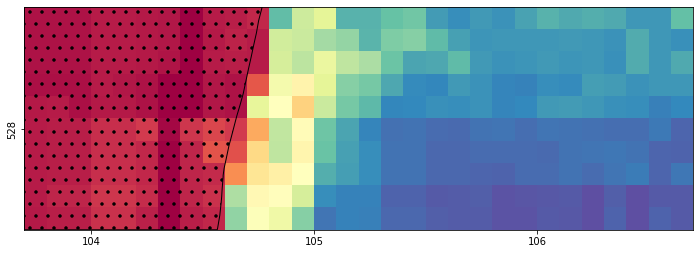

In [36]:
fig, ax = nlmod.plot.get_map(extent_hbossche)
nlmod.plot.data_array(ctop.isel(time=0), ds=ds, ax=ax, cmap="Spectral_r")
nlmod.plot.surface_water(ds, ax=ax, hatch=".", edgecolor="k", facecolor="none")

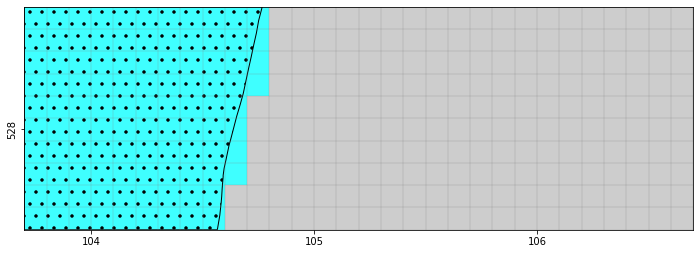

In [37]:
# plot using flopy
fig, ax = nlmod.plot.get_map(extent_hbossche)
pmv = fp.plot.PlotMapView(model=gwf, layer=0, ax=ax)
# pc = pmv.plot_array(c.isel(time=0), cmap="Spectral_r")
pmv.plot_bc("GHB", plotAll=True, alpha=0.5)
pmv.plot_bc("RCH", plotAll=True, alpha=0.1)
nlmod.plot.surface_water(ds, ax=ax, hatch=".", edgecolor="k", facecolor="none")
pmv.plot_grid(linewidth=0.25);

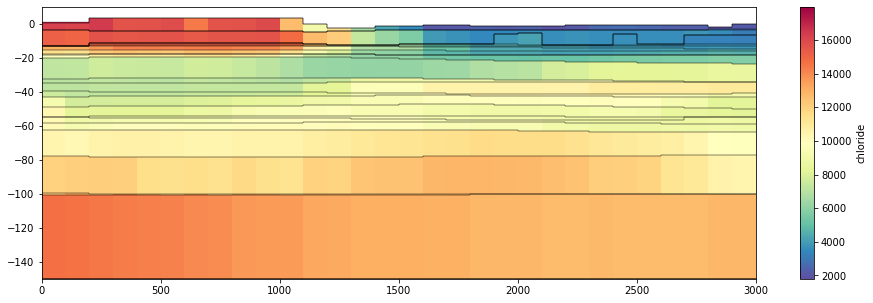

In [39]:
y = (ds.extent[2] + ds.extent[3]) / 2 + 0.1
line = [(ds.extent[0], y), (ds.extent[1], y)]
zmin = -150.0
zmax = 10.0

# plot using nlmod
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
dcs = nlmod.plot.DatasetCrossSection(ds, line=line, zmin=zmin, zmax=zmax, ax=ax)
pc = dcs.plot_array(c.isel(time=0), cmap="Spectral_r")
dcs.plot_grid(vertical=False, linewidth=0.25)
cbar = fig.colorbar(pc, ax=ax)
cbar.set_label("chloride")

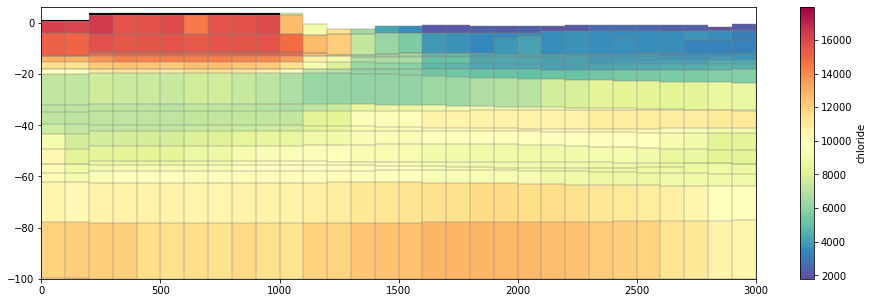

In [ ]:
# plot using flopy
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
pmv = fp.plot.PlotCrossSection(model=gwf, line={"line": line})
pc = pmv.plot_array(c.isel(time=0), cmap="Spectral_r")
pmv.plot_bc("GHB", color="k", zorder=10)
pmv.plot_grid(linewidth=0.25)
cbar = fig.colorbar(pc, ax=ax)
cbar.set_label("chloride")
ax.set_ylim(bottom=-100);